# Discrete Choice Modeling

For more detailed information, please see: 

Koppelman & Bhat (2006) A Self-Instructing Course in Mode Choice Modeling
http://www.caee.utexas.edu/prof/bhat/COURSES/LM_Draft_060131Final-060630.pdf 


### Motivation

Not everything has a continous dependent variable.  Some things are discrete.  Coke or Pepsi?  Soda or pop?  Let's think of a few...

Discrete choice models give us a way to model this.  


### Elements

In this framework, there are several elements to the choice decision process: 

- The decision maker
- The alternatives
- Attributes of the alternatives
- The decision rule


### Structure and Assumptions

We will use a multi-nomial logit (MNL) model.  It takes the form: 

$Pr(i) = \frac{e^U_i}{\sum_{j=1}^{J} U_j}$

where $U_i = \beta X_i + \epsilon_i$ and $\epsilon_i$ follows a Gumbel distribution. 

This equation defines the decision rule.  A bit of time to work it through...

### Libraries

Will be using [Statsmodels](http://statsmodels.sourceforge.net/).  Start with: 

    conda install statsmodels
    
    

### Today's objective

Today, we want to predict vehicle ownership.  

We'll be using the PUMS data again.  This time we'll use the household records instead of the person records, and households will be our decision-making unit.  You can find the data here: 

https://www.census.gov/programs-surveys/acs/data/pums.html

Please download the Kentucky 1-year household data.  

In [184]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf

# this allows plots to appear directly in the notebook
%matplotlib inline

In [185]:
# get the data
df = pd.read_csv('data/ss16hky.csv')
df.head()

,RT,SERIALNO,ST,DIVISION,PUMA,REGION,ADJHSG,ADJINC,WGTP,NP,...,wgtp71,wgtp72,wgtp73,wgtp74,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80
0,H,42,21,6,2700,3,1000000,1007588,25,5,...,8,24,26,23,28,25,38,37,40,35
1,H,45,21,6,2600,3,1000000,1007588,84,2,...,95,74,76,151,88,25,93,25,29,105
2,H,49,21,6,1704,3,1000000,1007588,82,2,...,87,69,29,83,108,24,27,128,83,141
3,H,121,21,6,1300,3,1000000,1007588,12,1,...,21,13,18,10,4,10,4,21,11,25
4,H,143,21,6,1400,3,1000000,1007588,53,2,...,17,56,61,107,41,44,66,64,81,51


In [186]:
# keep only occupied housing units
'''
NP 2
Number of person records following this housing record
00 .Vacant unit
01 .One person record (one person in household or any person in
.group quarters)
02..20 .Number of person records (number of persons in household)

TYPE 1
Type of unit
1 .Housing unit
2 .Institutional group quarters
3 .Noninstitutional group quarters
'''

df = df[df['TYPE']==1]
df = df[df['NP']>0]
len(df)

18038

### Look at the data

It is often a good idea to look at the data we want to model, and see how it relates to some variables we expect to be important.  We can do this using seaborn, which we learned about a few weeks ago.  

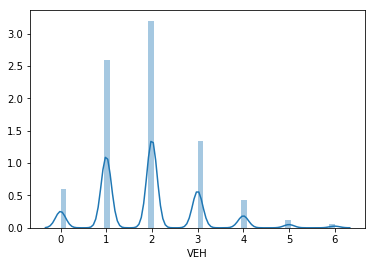

In [187]:
'''
10
VEH 1
Vehicles (1 ton or less) available
b .N/A (GQ/vacant)
0 .No vehicles
1 .1 vehicle
2 .2 vehicles
3 .3 vehicles
4 .4 vehicles
5 .5 vehicles
6 .6 or more vehicles
'''

sns.distplot(df['VEH'])

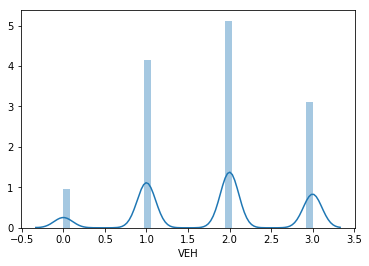

In [188]:
# there aren't very many above 3, so group all of those
df['VEH'] = df['VEH'].apply(lambda x : min(x, 3))
df['VEH'] = df['VEH'].astype(int)

sns.distplot(df['VEH'])

### Estimating a model

OK, that's fine, we can do plots, but we want some actual numbers.  For this, we want to estimate what the model coefficients are. 

In [189]:
# Here is the constants only model.
mod = smf.MNLogit.from_formula(formula='VEH ~ 1', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.258694
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                18038
Model:                        MNLogit   Df Residuals:                    18035
Method:                           MLE   Df Model:                            0
Date:                Wed, 11 Apr 2018   Pseudo R-squ.:                   0.000
Time:                        06:43:36   Log-Likelihood:                -22704.
converged:                       True   LL-Null:                       -22704.
                                        LLR p-value:                       nan
     VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4739      0.031     47.677      0.000       1.413       1.534
-----------------------------

Notice a few things: 

1. Goodness of fit measures
2. Separate coefficients for each alternative

In [190]:
# That's fine, but we may try some more things.  Perhaps age matters. 
# More people -> more cars? 

mod = smf.MNLogit.from_formula(formula='VEH ~ NP + 1', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.150948
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                18038
Model:                        MNLogit   Df Residuals:                    18032
Method:                           MLE   Df Model:                            3
Date:                Wed, 11 Apr 2018   Pseudo R-squ.:                 0.08560
Time:                        06:43:38   Log-Likelihood:                -20761.
converged:                       True   LL-Null:                       -22704.
                                        LLR p-value:                     0.000
     VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4213      0.073     19.599      0.000       1.279       1.563
NP             0.0314      0.

We can apply this model

### Categorical variables

We may also want to include categorical variables.  We can include them by calculating a 'dummy' variable, which is 1 if the value is in a category, and zero otherwise.  

In [191]:
'''
HUPAC 1
HH presence and age of children
b .N/A (GQ/vacant)
1 .With children under 6 years only
2 .With children 6 to 17 years only
3 .With children under 6 years and 6 to 17 years
4 .No children
'''

dummies = pd.get_dummies(df['HUPAC'])
dummies.columns = ['kids_u6', 'kids_6_17', 'kids_u6_and_617', 'no_kids']
df = df.join(dummies)
df.head()

,RT,SERIALNO,ST,DIVISION,PUMA,REGION,ADJHSG,ADJINC,WGTP,NP,...,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80,kids_u6,kids_6_17,kids_u6_and_617,no_kids
0,H,42,21,6,2700,3,1000000,1007588,25,5,...,28,25,38,37,40,35,0,1,0,0
1,H,45,21,6,2600,3,1000000,1007588,84,2,...,88,25,93,25,29,105,0,0,0,1
2,H,49,21,6,1704,3,1000000,1007588,82,2,...,108,24,27,128,83,141,0,1,0,0
3,H,121,21,6,1300,3,1000000,1007588,12,1,...,4,10,4,21,11,25,0,0,0,1
4,H,143,21,6,1400,3,1000000,1007588,53,2,...,41,44,66,64,81,51,0,0,0,1


In [192]:
# That's fine, but we may try some more things.  Perhaps age matters. 
# More people -> more cars? 

mod = smf.MNLogit.from_formula(formula='VEH ~ NP + kids_u6 + kids_6_17 + kids_u6_and_617 + 1', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.099254
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                18038
Model:                        MNLogit   Df Residuals:                    18023
Method:                           MLE   Df Model:                           12
Date:                Wed, 11 Apr 2018   Pseudo R-squ.:                  0.1267
Time:                        06:43:44   Log-Likelihood:                -19828.
converged:                       True   LL-Null:                       -22704.
                                        LLR p-value:                     0.000
          VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.5923      0.085     18.741      0.000       1.426       1.759
NP            

In [193]:
# what else should we add? 
df['HINCP'].head(150)

0      135200.0
1       62300.0
2      131000.0
3       18000.0
4       40300.0
5      100000.0
8       64500.0
9       63000.0
11      28600.0
12     192800.0
13      88000.0
15          0.0
16      53500.0
18     249000.0
19     101000.0
20      12000.0
22      20500.0
23      15670.0
26      41600.0
27      77000.0
28       8900.0
29      22800.0
32     103400.0
33      35000.0
34      64000.0
36      14900.0
37      21300.0
38      95000.0
39      48000.0
40      86800.0
         ...   
153     77400.0
154      5600.0
155     68700.0
157     69000.0
158     90260.0
159     27100.0
160     19000.0
161    249000.0
162     50000.0
163     96530.0
164    110500.0
165     20900.0
166     53800.0
167     71000.0
168    293200.0
169     53250.0
170     42600.0
171     32500.0
172     32400.0
173     37600.0
175    109000.0
176    108310.0
177     57200.0
180     67000.0
181     84800.0
182         0.0
183     10300.0
184     40000.0
187     45800.0
188     55000.0
Name: HINCP, Length: 150

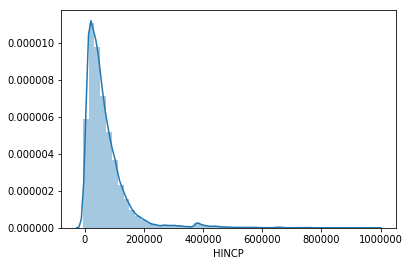

In [194]:
bins = [1, 35000, 50000, 80000, 100000, 500000]
labels = ['1d_to_35k', '35k_to_50k', '50k_to_80k',
                   '80k_to_100k','100k_to_500k']
df['income'] = pd.cut(df['HINCP'], bins=bins, labels=labels)
sns.distplot(df['HINCP'])

In [195]:
dummies = pd.get_dummies(df['income'])
dummies.columns = ['1d_to_35k', '35k_to_50k', '50k_to_80k',
                   '80k_to_100k','100k_to_500k']
df = df.join(dummies)
df.head()

,RT,SERIALNO,ST,DIVISION,PUMA,REGION,ADJHSG,ADJINC,WGTP,NP,...,kids_u6,kids_6_17,kids_u6_and_617,no_kids,income,1d_to_35k,35k_to_50k,50k_to_80k,80k_to_100k,100k_to_500k
0,H,42,21,6,2700,3,1000000,1007588,25,5,...,0,1,0,0,100k_to_500k,0,0,0,0,1
1,H,45,21,6,2600,3,1000000,1007588,84,2,...,0,0,0,1,50k_to_80k,0,0,1,0,0
2,H,49,21,6,1704,3,1000000,1007588,82,2,...,0,1,0,0,100k_to_500k,0,0,0,0,1
3,H,121,21,6,1300,3,1000000,1007588,12,1,...,0,0,0,1,1d_to_35k,1,0,0,0,0
4,H,143,21,6,1400,3,1000000,1007588,53,2,...,0,0,0,1,35k_to_50k,0,1,0,0,0


In [197]:
mod = smf.MNLogit.from_formula(formula='VEH ~ NP + 1d_to_35k + 35k_to_50k + 50k_to_80k + 80k_to_100k + 100k_to_500k', data=df)
res = mod.fit()
print(res.summary())

SyntaxError: invalid syntax (<unknown>, line 1)

### Homework

Calculate the probability that a 1-person household in Lexington, earning $16,000 per year owns 0, 1, 2 or 3+ vehicles.  